# Refitting NumPyro models with ArviZ (and xarray)

ArviZ is backend agnostic and therefore does not sample directly. In order to take advantage of algorithms that require refitting models several times, ArviZ uses `SamplingWrappers` to convert the API of the sampling backend to a common set of functions. Hence, functions like Leave Future Out Cross Validation can be used in ArviZ independently of the sampling backend used.

Below there is one example of `SamplingWrapper` usage for NumPyro.

In [1]:
import arviz as az
import numpyro
import numpyro.distributions as dist
import jax.random as random
from numpyro.infer import MCMC, NUTS
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import xarray as xr

In [2]:
numpyro.set_host_device_count(4)

For the example we will use a linear regression.

In [3]:
np.random.seed(26)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = np.random.normal(loc=b1 * xdata + b0, scale=sigma)

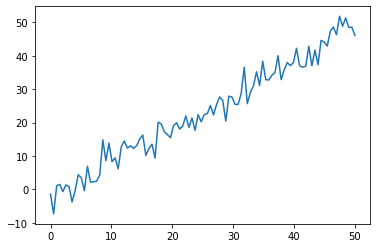

In [4]:
plt.plot(xdata, ydata)

Now we will write the NumPyro code:

In [5]:
def model(N, x, y=None):
    b0 = numpyro.sample("b0", dist.Normal(0, 10))
    b1 = numpyro.sample("b1", dist.Normal(0, 10))
    sigma_e = numpyro.sample("sigma_e", dist.HalfNormal(10))
    numpyro.sample("y", dist.Normal(b0 + b1 * x, sigma_e), obs=y)

In [6]:
data_dict = {
    "N": len(ydata),
    "y": ydata,
    "x": xdata,
}
kernel = NUTS(model)
sample_kwargs = dict(
    sampler=kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4, 
    chain_method="parallel"
)
mcmc = MCMC(**sample_kwargs)
mcmc.run(random.PRNGKey(0), **data_dict)

We have defined a dictionary `sample_kwargs` that will be passed to the `SamplingWrapper` in order to make sure that all refits use the same sampler parameters. We follow the same pattern with `az.from_numpyro`.

In [7]:
dims = {"y": ["time"], "x": ["time"]}
idata_kwargs = {
    "dims": dims,
    "constant_data": {"x": xdata}
}
idata = az.from_numpyro(mcmc, **idata_kwargs)
del idata.log_likelihood
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

We are now missing the `log_likelihood` group because we have not used the `log_likelihood` argument in `idata_kwargs`. We are doing this to ease the job of the sampling wrapper. Instead of going out of our way to get Stan to calculate the pointwise log likelihood values for each refit and for the excluded observation at every refit, we will compromise and manually write a function to calculate the pointwise log likelihood.

Even though it is not ideal to lose part of the straight out of the box capabilities of PyStan-ArviZ integration, this should generally not be a problem. We are basically moving the pointwise log likelihood calculation from the Stan code to the Python code, in both cases we need to manyally write the function to calculate the pointwise log likelihood.

Moreover, the Python computation could even be written to be compatible with Dask. Thus it will work even in cases where the large number of observations makes it impossible to store pointwise log likelihood values (with shape `n_samples * n_observations`) in memory.

In [8]:
def calculate_log_lik(x, y, b0, b1, sigma_e):
    mu = b0 + b1 * x
    return stats.norm(mu, sigma_e).logpdf(y)

This function should work for any shape of the input arrays as long as their shapes are compatible and can broadcast. There is no need to loop over each draw in order to calculate the pointwise log likelihood using scalars.

Therefore, we can use `xr.apply_ufunc` to handle the broadasting and preserve the dimension names:

In [9]:
log_lik = xr.apply_ufunc(
    calculate_log_lik,
    idata.constant_data["x"],
    idata.observed_data["y"],
    idata.posterior["b0"],
    idata.posterior["b1"],
    idata.posterior["sigma_e"],
)
idata.add_groups(log_likelihood=log_lik)

The first argument is the function, followed by as many positional arguments as needed by the function, 5 in our case. As this case does not have many different dimensions nor combinations of these, we do not need to use any extra kwargs passed to [`xr.apply_ufunc`](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html#xarray.apply_ufunc).

We are now passing the arguments to `calculate_log_lik` initially as `xr.DataArrays`. What is happening here behind the scenes is that `xr.apply_ufunc` is broadcasting and aligning the dimensions of all the DataArrays involved and afterwards passing numpy arrays to `calculate_log_lik`. Everything works automagically. 

Now let's see what happens if we were to pass the arrays directly to `calculate_log_lik` instead:

In [10]:
calculate_log_lik(
    idata.constant_data["x"].values,
    idata.observed_data["y"].values,
    idata.posterior["b0"].values,
    idata.posterior["b1"].values,
    idata.posterior["sigma_e"].values
)

ValueError: operands could not be broadcast together with shapes (4,1000) (100,) 

If you are still curious about the magic of xarray and `xr.apply_ufunc`, you can also try to modify the `dims` used to generate the InferenceData a couple cells before:

    dims = {"y": ["time"], "x": ["time"]}
    
What happens to the result if you use a different name for the dimension of `x`?

In [11]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> log_likelihood

We will create a subclass of `az.SamplingWrapper`. Therefore, instead of having to implement all functions required by `az.reloo` we only have to implement `sel_observations` (we are cloning `sample` and `get_inference_data` from the `PyStanSamplingWrapper` in order to use `apply_ufunc` instead of assuming the log likelihood is calculated within Stan). 

Note that of the 2 outputs of `sel_observations`, `data__i` is a dictionary because it is an argument of `sample` which will pass it as is to `model.sampling`, whereas `data_ex` is a list because it is an argument to `log_likelihood__i` which will pass it as `*data_ex` to  `apply_ufunc`. More on `data_ex` and `apply_ufunc` integration below.

In [12]:
class NumPyroSamplingWrapper(az.SamplingWrapper):
    def __init__(self, model, **kwargs):        
        self.rng_key = kwargs.pop("rng_key", random.PRNGKey(0))
        
        super(NumPyroSamplingWrapper, self).__init__(model, **kwargs)
    
    def sample(self, modified_observed_data):
        self.rng_key, subkey = random.split(self.rng_key)
        mcmc = MCMC(**self.sample_kwargs)
        mcmc.run(subkey, **modified_observed_data)
        return mcmc

    def get_inference_data(self, fit):
        # Cloned from PyStanSamplingWrapper.
        idata = az.from_numpyro(mcmc, **self.idata_kwargs)
        return idata
    
class LinRegWrapper(NumPyroSamplingWrapper):
    def sel_observations(self, idx):
        xdata = self.idata_orig.constant_data["x"]
        ydata = self.idata_orig.observed_data["y"]
        mask = np.isin(np.arange(len(xdata)), idx)
        # data__i is passed to numpyro to sample on it -> dict of numpy array
        # data_ex is passed to apply_ufunc -> list of DataArray
        data__i = {"x": xdata[~mask].values, "y": ydata[~mask].values, "N": len(ydata[~mask])}
        data_ex = [xdata[mask], ydata[mask]]
        return data__i, data_ex


In [13]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.92     7.20
p_loo        3.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In this case, the Leave-One-Out Cross Validation (LOO-CV) approximation using Pareto Smoothed Importance Sampling (PSIS) works for all observations, so we will use modify `loo_orig` in order to make `az.reloo` believe that PSIS failed for some observations. This will also serve as a validation of our wrapper, as the PSIS LOO-CV already returned the correct value.

In [14]:
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

We initialize our sampling wrapper. Let's stop and analize each of the arguments. 

We then use the `log_lik_fun` and `posterior_vars` argument to tell the wrapper how to call `xr.apply_ufunc`. `log_lik_fun` is the function to be called, which is then called with the following positional arguments:

    log_lik_fun(*data_ex, *[idata__i.posterior[var_name] for var_name in posterior_vars]
    
where `data_ex` is the second element returned by `sel_observations` and `idata__i` is the InferenceData object result of `get_inference_data` which contains the fit on the subsetted data. We have generated `data_ex` to be a tuple of DataArrays so it plays nicely with this call signature.

We use `idata_orig` as a starting point, and mostly as a source of observed and constant data which is then subsetted in `sel_observations`.

Finally, `sample_kwargs` and `idata_kwargs` are used to make sure all refits and corresponding InferenceData are generated with the same properties.

In [15]:
pystan_wrapper = LinRegWrapper(
    mcmc, 
    rng_key=random.PRNGKey(7),
    log_lik_fun=calculate_log_lik, 
    posterior_vars=("b0", "b1", "sigma_e"),
    idata_orig=idata, 
    sample_kwargs=sample_kwargs, 
    idata_kwargs=idata_kwargs
)

And eventually, we can use this wrapper to call `az.reloo`, and compare the results with the PSIS LOO-CV results.

In [16]:
loo_relooed = az.reloo(pystan_wrapper, loo_orig=loo_orig)

/home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 13
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 13
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 42
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 42
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 56
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 56
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 73
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 73


In [17]:
loo_relooed

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.89     7.20
p_loo        3.08        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
loo_orig

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.92     7.20
p_loo        3.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%